<a href="https://colab.research.google.com/github/qcuongning/collab/blob/main/Thyroid_nodule_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Với các hàm cần sử dụng backend Keras mà bị lỗi K not contribute cần đổi về keras==2.2.4


The codebase is heavily inspired by the [respotory](https://github.com/qubvel/efficientnet)



# Get Data

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import json
import cv2
import csv
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications as app
seed = 1234
np.random.seed(seed)
from zipfile import ZipFile


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#su dung khi dataset o trong drive neu khong bo qua
%cp drive/My\ Drive/thyroid/thyroid.zip /content/
with ZipFile('thyroid.zip', 'r') as tt:
  tt.extractall("thyroid")

In [8]:
file_name = 'weights_save'
if not os.path.exists(file_name):
  os.mkdir(file_name)

# Initial Data

lấy các cặp ảnh và mask

ảnh resize về 192x288

mask là binary
đầu ra imgs , masks

In [9]:
def resize_pad(blob):
    high,width = blob.shape[:2]
    if high >= width:
        blob = cv2.resize(blob,(int(96*width/high),96))
        delta = 96 - 96*width/high
        left,right =  int(delta//2),int(delta//2)
        top,bottom  = 0, 0
    else:
        blob = cv2.resize(blob,(96,int(96*high/width)))
        delta = 96 - 96*high/width
        top,bottom = int(delta//2),int(delta//2)
        left,right = 0,0
    #imgs.append(blob)
    new_im = cv2.copyMakeBorder(blob, top, bottom, left, right, cv2.BORDER_CONSTANT,value=0)
    new_im = cv2.resize(new_im,(96,96))
    return new_im

In [133]:
import xml.etree.ElementTree as ET

ff = os.listdir("thyroid")
folder = "thyroid/"
basics = []
context = []
margin = []
masks = []
labels = []
# h, w = 352 // 2, 512 // 2
for count, f in enumerate(ff):
    rd_num = np.random.uniform(0.7, 1)
    if f.find(".jpg") > 0:
        img = cv2.imread(folder + f)
        
        ix_number = f.find("_")
        rep = f[ix_number + 1:ix_number + 2]
        if ix_number < 0:
            ix_number = f.find(".")
        number = f[:ix_number]
        if number == "127" or number == '54' or number == '165' or number == '176' or number == '203' or number == '205' or number == '166' or number == '197':
            continue
        root = ET.parse(folder + number + ".xml").getroot()
        lb = (root.find("tirads").text)
        if lb in ('4a','4b','4c','5'):
            tt = 1
        else:
            tt = 0
        for neighbor in root.findall("mark"):   # moi mark la mot anh trong mark co cac thuoc tinh </image>,</svg>
            if rep != neighbor.find("image").text:
                continue
            svg = neighbor.find("svg").text
            if svg is None:
                continue
            ss = eval(svg)
            for s in ss:
                if s["regionType"] =='arrow':
                    continue

                mask = np.zeros_like(img)
                contour = []
                for point in s["points"]:
                    x = point["x"]
                    y = point['y']
                    contour.append([[x, y]])
                contour = np.asarray(contour)
                cv2.drawContours(mask, [contour], 0, 255, 25)
                rect = cv2.boundingRect(contour)
                x,y,w,h = rect
                if w<50 or h <50:
                    continue
                # if w >= h:   
                #     offset = w - h
                #     h1,h2,w1,w2 = y-offset//2-w//20,y+h+offset//2+w//20,x-w//20,x+w+w//20
                #     h1 = max(h1,0)
                #     w1 = max(w1,0)
                #     blob= img[h1:h2,w1:w2]
                # else:
                #     offset = h - w
                #     h1,h2,w1,w2 =y-h//20,y+h+h//20,x-offset//2-h//20,x+w+offset//2+h//20
                #     h1 = max(h1,0)
                #     w1 = max(w1,0)
                #     blob= img[h1:h2,w1:w2]
                mg = cv2.bitwise_and(mask,img)

                h1,h2,w1,w2 = y,y+h,x,x+w
                blob= img[h1:h2,w1:w2]
                blob2 = mg[h1:h2,w1:w2]
                new_mg = resize_pad(blob2)
                new_im = resize_pad(blob)
                basics.append(new_im)
                margin.append(new_mg)
                h1,h2,w1,w2 = max(y-h//5,0),y+h+h//5,max(x-w//5,0),x+w+w//5
                blob= img[h1:h2,w1:w2]
                new_im = resize_pad(blob)
                context.append(new_im)


                
                labels.append(tt)
basics = np.asarray(basics,dtype = np.float32)
context = np.asarray(context,dtype = np.float32)
margin = np.asarray(margin,dtype = np.float32)
labels = np.asarray(labels,dtype = np.float32)
from sklearn.utils import shuffle
basics,context,margin, labels = shuffle(basics,context,margin, labels )
print(basics.shape,context.shape,margin.shape,labels.shape)

(606, 96, 96, 3) (606, 96, 96, 3) (606, 96, 96, 3) (606,)


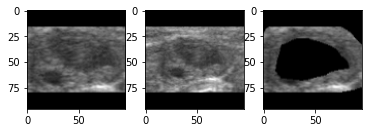

In [78]:
i = 10
plt.subplot(131).imshow(basics[i,:,:,0],cmap='gray')
plt.subplot(132).imshow(context[i,:,:,0],cmap='gray')
plt.subplot(133).imshow(margin[i,:,:,0],cmap='gray')

In [134]:
from keras.utils.np_utils import to_categorical  
labels = to_categorical(labels,2)
n2 = 500
x_train1 = basics[:n]
x_dev1 = basics[n:]

x_train2 = context[:n2]
x_dev2 = context[n2:]

x_train3 = margin[:n]
x_dev3 = margin[n:]


y_train = labels[:n2]
y_dev = labels[n2:]

In [135]:
step = 0
xs,ys=[x_train2],[y_train]
for x,y in datagen.flow(x_train2, y_train, batch_size=32,save_to_dir="weights_save"):
    step+=1
    if step==30:
        break
    xs.append(x)
    ys.append(y)

x_train2 = np.concatenate(xs)
y_train = np.concatenate(ys)

In [136]:
x_train2, y_train = shuffle(x_train2, y_train )


In [14]:
from sklearn.metrics import f1_score, recall_score, precision_score

class show_metrics(tf.keras.callbacks.Callback):
    def __init__(self,x_dev,y_dev):
        super(show_metrics, self).__init__()
    def on_epoch_end(self, epoch, logs=None):
        y_score = self.model.predict(x_dev)
        print(f"f1 score:{f1_score(y_dev,y_score)}, recall: {recall_score(y_dev,y_score)}, precision: {precision_score(y_dev,y_score)}")


        

In [15]:
def f1(y_true,y_pred):
    return f1_score(y_true,y_pred)

# Fit model

Epoch 60/80
500/500 [==============================] - 288s 576ms/step - loss: 0.3507 - acc: 0.9603 - dice_coef: 0.9069 - jaccard_coef: 0.8409 - val_loss: 0.4036 - val_acc: 0.9290 - val_dice_coef: 0.8515 - val_jaccard_coef: 0.7673

In [ ]:
input_ten=Input(shape=(96,96,3))
pretrain = app.ResNet50(include_top = True, weights=None, input_tensor=input_ten)
print(pretrain.summary())

In [114]:
def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = K.mean(tensor, axis=(1,2), keepdims=True)
    std = K.std(tensor, axis=(1,2), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    
    return mvn
def zfnet(tensor,dense_out):
    mvn0 = Lambda(mvn)(tensor)
    conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    #conv1 = block_inception_a(conv1)
    conv1 = Conv2D(64, 3,  padding = 'same')(conv1)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3,  padding = 'same')(pool1)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    #conv2 = block_inception_a(conv2)
    conv2 = Conv2D(128, 3,  padding = 'same')(conv2)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3,  padding = 'same')(pool2)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    #conv3 = block_inception_a(conv3)
    conv3 = Conv2D(256, 3,  padding = 'same')(conv3)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3,  padding = 'same')(pool3)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
   # conv4 = block_inception_a(conv4)
    conv4 = Conv2D(512, 3,  padding = 'same')(conv4)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3,  padding = 'same')(pool4)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    #conv5 = block_inception_a(conv5)
    conv5 = Conv2D(1024, 3,  padding = 'same')(conv5)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    drop5 = Dropout(0.5)(conv5)

    
    # dense1 = Dense(512,activation='relu')(flat1)
    # dense1 = Dropout(0.5)(dense1)
    # dense1 = Dense(512,activation='relu')(dense1)
    # dense1 = Dropout(0.5)(dense1)
    # dense1 = Dense(dense_out,activation='relu')(dense1)


    return flat1



In [126]:
def classify(shape = (96,96,3)):
    #basic = Input(shape=shape)
    context = Input(shape=shape)
    #margin = Input(shape=shape)
    # basic_body = app.ResNet50(include_top=False,weights = 'imagenet', input_tensor=basic)
    context_body = app.ResNet50(include_top=False,weights = 'imagenet', input_tensor=context)
    # margin_body = app.ResNet50(include_top=False,weights = 'imagenet', input_tensor=margin)
    #basic_body = zfnet(basic,256)
    #context_body = zfnet(context,256)
    #margin_body = zfnet(margin,64)
    # basic_out = basic_body.output
    # context_out = context_body.output
    # margin_out = margin_body.output

    flat1 = Flatten()(context_body.layers[-5].output)
    #conten = Concatenate()([basic_body,context_body,margin_body])
    dense = Dense(256,activation='relu')(flat1)
    dense = Dropout(0.5)(dense)

    dense = Dense(2,activation='softmax')(dense)
    model=Model(inputs=[context],outputs=dense)
    return model

In [137]:
model= classify()
sgd = RMSprop(lr = 0.0001)

model.compile(optimizer = sgd, loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
print(x_train2.shape,y_train.shape,x_dev2.shape,y_dev.shape)
history = model.fit(x_train2,y_train,batch_size=16,epochs = 50, 
                    validation_data = (x_dev2, y_dev))

(1416, 96, 96, 3) (1416, 2) (106, 96, 96, 3) (106, 2)
Epoch 1/50
89/89 [==============================] - 5s 55ms/step - loss: 0.6854 - accuracy: 0.6208 - val_loss: 0.6441 - val_accuracy: 0.6604
Epoch 2/50
89/89 [==============================] - 4s 46ms/step - loss: 0.5425 - accuracy: 0.7119 - val_loss: 2.1925 - val_accuracy: 0.6321
Epoch 3/50
89/89 [==============================] - 4s 46ms/step - loss: 0.3696 - accuracy: 0.8383 - val_loss: 4.2503 - val_accuracy: 0.6226
Epoch 4/50
89/89 [==============================] - 4s 46ms/step - loss: 0.2665 - accuracy: 0.8976 - val_loss: 4.3665 - val_accuracy: 0.6698
Epoch 5/50
89/89 [==============================] - 4s 46ms/step - loss: 0.1540 - accuracy: 0.9435 - val_loss: 4.1670 - val_accuracy: 0.6509
Epoch 6/50
89/89 [==============================] - 4s 46ms/step - loss: 0.1826 - accuracy: 0.9421 - val_loss: 3.2408 - val_accuracy: 0.6792
Epoch 7/50
89/89 [==============================] - 4s 46ms/step - loss: 0.1098 - accuracy: 0.9576 -

Epoch 49/50
35/35 [==============================] - 1s 23ms/step - loss: 0.0108 - accuracy: 0.9964 - val_loss: 5.0408 - val_accuracy: 0.7358

pre_out=pretrain.get_layer("conv3_block4_out").output
flat=Flatten()(pre_out)
predict=Dense(256,activation='relu')(flat)
predict=Dense(2,activation='sigmoid')(predict)

loss: 0.0438 - accuracy: 0.9929 - val_loss: 1.7568 - val_accuracy: 0.7879

(1400, 96, 96, 3) (1400, 2) (132, 96, 96, 3) (132, 2)

resnet50 -5




In [138]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

y_pre=model.predict(x_train2)
y_pre=np.asarray(y_pre,dtype=np.float)

average_precision = average_precision_score(y_train, y_pre)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 1.00


In [152]:
img = cv2.imread('/content/lbox_1385.jpg')
img = cv2.resize(img,(96,96))
img = np.expand_dims(img,0)
y_pre=model.predict(img)

In [153]:
print(y_pre)

[[0.00814239 0.9918576 ]]
